In [1]:
import sys
functions_at = '/proj/src'
sys.path.append(functions_at)
from Py.libs import *
from Py.func import *

input_paths = read_json('/proj/results/Py/input_paths.json')
save_at = '/proj/results/Py/feature_importance'
if not os.path.exists(save_at):
    os.makedirs(save_at, exist_ok = True)
task_name = "feature_importance"
out_paths = input_paths # so that more keys-value pairs are appneded to an existing dictionary. should remove it and set out_paths to a dictionary if connection to the next step is needed
out_paths['base_folder'] = f'{save_at}'
out_paths['feature_imp_scores'] = f'{save_at}/feature_imp_scores.csv'

In [2]:
# Produce data ----------------------------------------------------------------------------------------------------
ec_data_raw = pd.read_feather(input_paths["ec_data"]).drop(['idx', 'env'], axis=1).rename(columns={"harvest_env": "idx"}).set_index('idx')
feature_imp_data = pd.read_csv(input_paths['clust_data'])

# format the data 
predictors = ec_data_raw.columns.values.tolist()

In [3]:
## Drop duplicates
data_fil = feature_imp_data.loc[:, ["groups"] + predictors].drop_duplicates().reset_index(drop = True)

## Define data for classifier
y_0 = data_fil.loc[:, 'groups'].values.astype('int').tolist()
y = [x -1 for x in y_0] # adjust indices for python
X = data_fil.loc[:, predictors].astype('float32')

## change colnames
col_names = pd.DataFrame({"old" : X.columns,
                          "new" : ["var_" + str(i) for i in range(0, len(X.columns))]})
X.columns = col_names['new']

## create splits
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42 )

## define eval set
evalset = [(train_x, train_y), (test_x, test_y)]

In [4]:
# Define classifier
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

#‘weight’: the number of times a feature is used to split the data across all trees.
#‘gain’: the average gain across all splits the feature is used in.
#‘cover’: the average coverage across all splits the feature is used in.
#‘total_gain’: the total gain across all splits the feature is used in.
#‘total_cover’: the total coverage across all splits the feature is used in.

desired_type = importance_types[1]
model = XGBClassifier(n_jobs = 60, 
                      importance_type = desired_type,
                      learning_rate=0.1,
                      n_estimators=3000,
                      max_depth=30,
                      early_stopping_rounds = 100,
                      eval_metric='mlogloss',
                      seed=27,
                      verbosity = 0) # 3 for debug

# Training the model on the training data
model.fit(train_x, train_y, eval_set = evalset,  verbose = False) #https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/

## Test_set accuracy
predictions_test = model.predict(test_x)

# Calculating accuracy
logging.info(f'Test set: Accurately predicted {accuracy_score(test_y, predictions_test, normalize=False)} out of {len(test_y)} instances')
logging.info(f'Test accuracy:, {round(accuracy_score(test_y, predictions_test), 2)}')

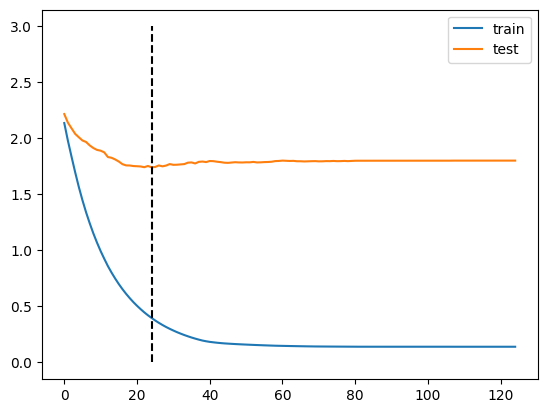

In [5]:
# Retrieve performance metrics
results = model.evals_result()
all_vals = results['validation_0']['mlogloss'] + results['validation_1']['mlogloss']

# Plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.vlines(model.best_iteration, 0, int(math.ceil(max(all_vals))), linestyles = "dashed", color = "black")

# Show the legend
plt.legend()

In [6]:
# Extract feature importance scores
default_values = pd.DataFrame({f'{desired_type}' : model.feature_importances_},
                              index = train_x.columns.astype('str')).merge(col_names, left_index = True, right_on = 'new', how = "left")

#property feature_importances_: ndarray
#    Feature importances property, return depends on importance_type parameter. When model trained with
#    multi-class/multi-label/multi-target dataset, the feature importance is “averaged” over all targets. 
#    The “average” is defined based on the importance type. For instance, if the importance type is “total_gain”, then
#    the score is sum of loss change for each split from all trees.
#        Returns
#            • feature_importances_ (array of shape [n_features] except for multi-class)
#            • linear model, which returns an array with shape (n_features, n_classes)
#    feature_importances_ has the same values as get_score(), except that the values of the former are scaled so that they sum to 1.
#sum(default_values['gain'].values) # pretty close to 1

# Extract all
feature_df = None
for f_type in importance_types:
    importance_scores = model.get_booster().get_score(importance_type = f_type)
    score_row = pd.DataFrame(importance_scores, index = [f'{f_type}'])
    print(len(score_row.columns))
    if feature_df is None:
        feature_df = score_row
    else:
        feature_df = pd.concat([feature_df, score_row])
feature_df_transpose = feature_df.transpose() # Zero-importance features will not be included
scores_df = default_values.merge(feature_df_transpose, left_on = 'new', right_index = True, how = "left", suffixes = ['_scaled', '_raw']).drop(['new'], axis = 1)

97
97
97
97
97


In [7]:
scores_df

,gain_scaled,old,weight,gain_raw,cover,total_gain,total_cover
0,0.009557,"air_temp_5cm_avg..C._(0,30]",6.0,1.232430,4.427395,7.394579,26.564373
1,0.040434,"air_temp_5cm_avg..C._(30,60]",3.0,5.214050,6.821792,15.642151,20.465376
2,0.000000,"air_temp_5cm_avg..C._(60,90]",NaN,NaN,NaN,NaN,NaN
3,0.005060,"air_temp_5cm_avg..C._(90,120]",4.0,0.652536,3.423187,2.610143,13.692747
4,0.000000,"air_temp_5cm_avg..C._(120,150]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
292,0.000000,"wind_speed_min..kph._(180,210]",NaN,NaN,NaN,NaN,NaN
293,0.011698,"wind_speed_min..kph._(210,240]",32.0,1.508528,4.156409,48.272907,133.005096
294,0.000000,"wind_speed_min..kph._(240,270]",NaN,NaN,NaN,NaN,NaN
295,0.000000,"wind_speed_min..kph._(270,300]",NaN,NaN,NaN,NaN,NaN


In [9]:
## cross validation with my data
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

model_cv = XGBClassifier(n_jobs = 60, 
                      importance_type = desired_type,
                      learning_rate=0.1,
                      n_estimators=3000,
                      max_depth=30,
                      eval_metric='mlogloss',
                      seed=27,
                      verbosity = 0) # 3 for debug
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_cv, X, y, scoring='accuracy', cv=cv, n_jobs=60)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/proj/py_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/proj/py_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/proj/py_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.521 (0.119)


In [ ]:
# Exp

## define train and test data
all_idx = data_x.index.values.tolist()
total_samples = len(all_idx)

test_idx = random.sample(all_idx, int(0.2*total_samples))
train_idx = [x for x in all_idx if x not in test_idx]
random.shuffle(train_idx) # shuffle the train idx

train_x, train_y =  data_x.loc[train_idx, :], feature_imp_data.loc[train_idx, "Env_coded"].values.astype('int').tolist()
test_x, test_y = data_x.loc[test_idx, :], feature_imp_data.loc[test_idx, "Env_coded"].values.astype('int').tolist()
